In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import scipy.signal as sig

import panel as pn
from bokeh.resources import INLINE

pn.extension()

sns.set_context(context='talk')

# Spectral analysis Part I

Spectral analysis is used to determine the amount of variance (energy) of a time series at particular frequencies. Thus, it is useful to identify periodicities in a time series or to identify time (or space) scales on which a quantity varies most.

In [2]:
# periodic signal plus red noise
n=100

np.random.seed(3)
xi = sns.distributions.stats.norm().rvs(size=(n))
a = .5
red = np.empty_like(xi)

red[0] = xi[0]
for i in range(1, xi.shape[-1]):
    red[i] = a * red[i - 1] + np.sqrt(1-a**2)*xi[i]
t = np.arange(n)

sin = np.sin(t * 2 * np.pi / 25)

red_sin = sin + .5 * red

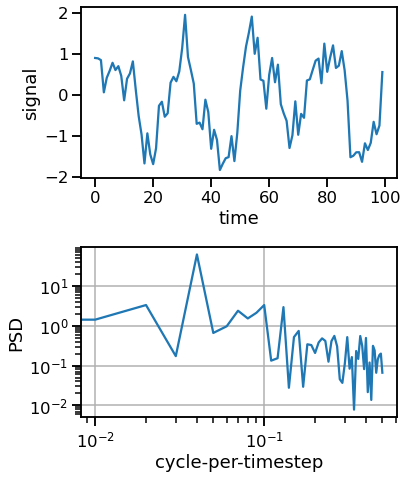

In [3]:
fft = np.fft.rfft(red_sin)
omega_r = 2 * np.pi * np.fft.rfftfreq(n)

amp = np.abs(fft) / n
amp[1:] *= 2.

Phi = amp ** 2
Phi[1:] /= 2.

df = 1 / n 
PSD = Phi / df


plt.figure(figsize=(6, 7))

plt.subplot(2, 1, 1)
plt.plot(t, red_sin)
plt.xlabel("time")
plt.ylabel("signal")

plt.subplot(2, 1, 2)
plt.loglog(omega_r / 2 / np.pi, PSD)
plt.xlabel("cycle-per-timestep")
plt.ylabel("PSD")
plt.grid();

plt.tight_layout()
# plt.savefig(
#     '../../lecture/img/8_example_spectrum.svg',
#     bbox_inches='tight',
#     pad_inches=.1
# );

---
## Prelude: Scalar Projections, Basis and Function Space

A scalar projection is an operation mapping two vectors (elements of a vector space) onto a scalar such as a real or complex number. Think about two vectors a, b in $\mathbb{R}^2$. The scalar projection of a onto b is the length $a_1$ of the orthogonal projection of a onto b.

<div align='center'>
<a title="Paolo.dL [CC BY-SA 3.0 (https://creativecommons.org/licenses/by-sa/3.0)], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Projection_and_rejection.png"><img width="256" alt="Projection and rejection" src="https://upload.wikimedia.org/wikipedia/commons/9/98/Projection_and_rejection.png"align='center'></a>
</div>

A necessary requirement is that the vector space has a scalar product ($<\dot{},\ddot{}>$) defined. With the scalar product, the scalar projection in this example is given by

$$ a_1 = \frac{<\vec{a},\vec{b}>}{\Vert \vec{b} \Vert}$$

where 

$$ \Vert \vec{b} \Vert = \sqrt{<\vec{b}, \vec{b}>}$$

Typically, the elements of a vector space are expressed as a linear combination of a set of vectors how are suitable to discribe any element of the vector space in a unique way. Such a set is called a **basis**. The coefficients of the linear combination are called the coordinates of the vector. If both the vector and a basis are defined using the same basis, then are the coordinates of the vector with respect to the new basis are given by the scalar projection of the vector on each basis vector.

<a title="Maschen [CC0], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:3d_two_bases_same_vector.svg"><img width="200px" alt="3d two bases same vector" src="https://upload.wikimedia.org/wikipedia/commons/f/f4/3d_two_bases_same_vector.svg"></a>

We may extend the concept of the vector space to a set of functions between two vector spaces. Think about a discrete time series of N samples which may be understood as a function mapping the time vector to our data, both elements of $\mathbb{R}^N$. The canonical basis of such a function space is the set of N functions $b_i(t)$.

The scalar product of such a vector space is inherited from $\mathbb{R}^N$

$$ b_i(t) =
\begin{cases}
1 \quad \text{if } t = i\\
0 \quad \text{else}
\end{cases}$$

$$ <f, g> = \sum_{i=1}^N f(i)g(i)$$

Column
    [0] Row
        [0] Matplotlib(Figure, name='interactive00055')
    [1] Column
        [0] DiscreteSlider(formatter='%d', name='i', options=[1, 2, 3, 4, 5, 6, 7], value=6)
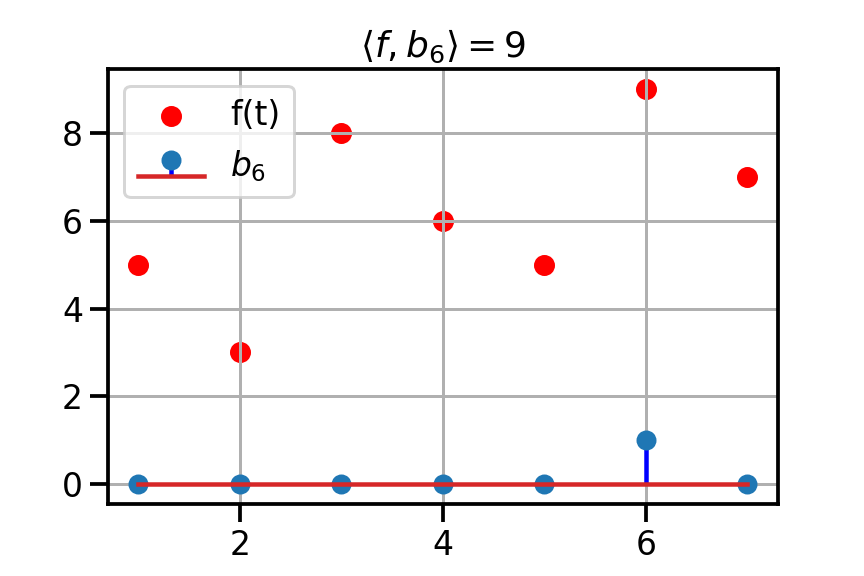

In [5]:
time = np.arange(1, 8)

def plot_basevector(i=6):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.subplots()
    data = np.array([5, 3, 8, 6, 5, 9, 7])
    plot = plt.scatter(time, data, c='r', label='f(t)');
    plt.stem(time, time==i, 'b', label='$b_{}$'.format(i), use_line_collection=True);
    plt.legend(loc=2);
    plt.title(r"$\left< f, b_{} \right> = {}$".format(i, data[i-1]))
    plt.grid()
    plt.close(fig)
    return fig

# plot_basevector();

p = pn.interact(plot_basevector, i=np.arange(1, 8));
panel = pn.Column(p[1], p[0])
panel

In [6]:
# panel.save("../../lecture/img/8_basis_function.html", embed=True, resources=INLINE)

---
## The Fourier Transform

The complex fourier transform uses complex exponential functions as a basis for the function vector space. The coordinates in frequency space are complex and represent amplitude and phase of a sinosoidal signal. The corresponding transformations from time space to frequency space for a continuous signal are given by

$$ F(\omega) = \int_{-\infty}^\infty f(t) e^{-i \omega t} dt$$

$$ f(t) = \frac{1}{2\pi} \int_{-\infty}^\infty F(\omega)e^{i \omega t} d\omega$$

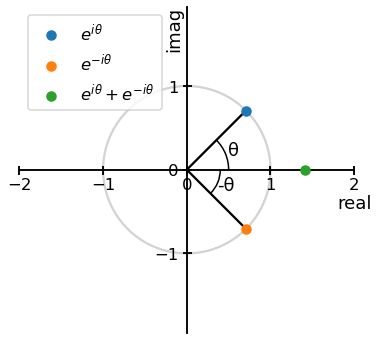

In [7]:
angle_slider = pn.widgets.FloatSlider(
    start=0., end=np.pi, step=.1, value=np.pi / 4,
    align='center',
)

@pn.depends(angle_slider.param.value)
def plot_complex_plane(θ=np.pi / 4):
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.subplots()
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    # Show ticks on the left and lower axes only (and let them protrude in both directions)
    ax1.xaxis.set_tick_params(bottom='on', top='off', direction='inout')
    ax1.yaxis.set_tick_params(left='on', right='off', direction='inout')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.yaxis.set_ticks_position('left')
    # Make spines pass through zero of the other axis
    ax1.spines['bottom'].set_position('zero')
    ax1.spines['left'].set_position('zero')

    z = np.exp(1j * θ)
    z_c = np.exp(-1j * θ)
    
    angle = np.linspace(-np.pi, np.pi, 100)
    
    plt.plot((0, z.real), (0, z.imag), 'k', zorder=0)
    ax1.add_patch(patches.Arc((0, 0), 1, 1, theta2=np.angle(z) * 180 / np.pi))
    plt.annotate("θ", (.6 * np.sqrt(z).real, .6 * np.sqrt(z).imag), ha="center", va='center')

    plt.plot((0, z_c.real), (0, z_c.imag), 'k', zorder=0)
    ax1.add_patch(patches.Arc((0, 0), .8, .8, theta1=np.angle(z_c) * 180 / np.pi))
    plt.annotate("-θ", (.5 * np.sqrt(z_c).real, .5 * np.sqrt(z_c).imag), ha="center", va='center')

    plt.plot(np.cos(angle), np.sin(angle), color='lightgrey', zorder=0)

    plt.scatter(z.real, z.imag, label=r'$e^{i\theta}$', zorder=5)
    plt.scatter(z_c.real, z_c.imag, label=r'$e^{-i\theta}$', zorder=5)
    plt.scatter((z + z_c).real, (z + z_c).imag, label=r"$e^{i\theta} + e^{-i\theta}$", zorder=5)

    plt.xlabel('real')
    ax1.set_xlabel('real')
    ax1.xaxis.set_label_coords(1.00, .5-0.075)
    ax1.set_ylabel('imag', ha='right')
    ax1.yaxis.set_label_coords(.5-0.01, 1.)
    plt.legend(
        loc='upper left')
    ax1.axis('equal')
    ax1.set(ylim=(-2, 2), xlim=(-2, 2), yticks=np.arange(-2, 3, 1))
#     plt.close()
    return fig

plot_complex_plane();
# panel = pn.Column(
#     angle_slider,
#     plot_complex_plane
# )
# panel

In [8]:
# panel.save("../../lecture/img/8_complex_exp.html", embed=True, max_opts=(np.pi *10)+1, resources=INLINE)

In practice, our signals are discrete measurements in time. The transformations, as [implemented in numpy](https://docs.scipy.org/doc/numpy/reference/routines.fft.html#implementation-details), for a time series $a_m$ of length $n$ and sampling distance $\Delta t$ are given by

$$A_k = \sum_{m=0}^{n-1} a_m e^{-i\omega_k m\Delta t}$$

$$ a_m = \frac{1}{n}\sum_{k=-n/2}^{n/2} A_k e^{i\omega_k m \Delta t}$$

with  $\omega_k = 2\pi f_k = \frac{2\pi k}{n\Delta t}$ and $k=-\frac{n}{2}, ...., \frac{n}{2}$.

- The lowest resolved frequency is zero, the mean of the time series.
- The highest resolved frequency is half the sampling rate and is called the *Nyquist frequency* $\nu = \frac{1}{2\Delta t}$.
- The difference between two neighboring frequencies (bandwidth) is given by $\Delta f = \frac{1}{n\Delta t}$.
- The total number of frequencies is $n$.

The frequencies that are resolved are a direct result of the length of the time series chosen for Fourier Transform.

In [10]:
n = 60
dt = 1.
t = np.arange(0, n, dt)

signal = (
    3. * np.sin(2 * np.pi * t / 15)
    + 1 * np.cos(2 * np.pi * t / 7.5  + np.pi / 4.)
    + 1.5
)

fft = np.fft.fftshift(np.fft.fft(signal))
omega = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(n))

freq_slider = pn.widgets.IntSlider(
    name='k', start=0, end=int(n//2), step=1, value=0,
    orientation='horizontal',
    align='center',
)

@pn.depends(freq_slider.param.value)
def plot_ts(k):
    fig = plt.figure(figsize=(6, 3))
    plt.plot(t, signal, label='signal')
    o = 2 * np.pi * k / n / dt
    plt.plot(t, np.exp(-1j*o*t).real, label=r'$\operatorname{Re}\left(e^{-i\omega_{' + str(k) + r'} t}\right)$')
    plt.xlabel('time')
    plt.legend(loc='center left', bbox_to_anchor= (1.01, .5))
    plt.tight_layout()
    plt.close()
    return fig

@pn.depends(freq_slider.param.value)
def plot_Ak(k):
    fig = plt.figure(figsize=(6, 3))
    i = k + n // 2
    im = -k + n // 2
    o = omega[i]
    plt.scatter(fft.real, fft.imag, c='k', label="$A_k$")
    plt.scatter(fft.real[i], fft.imag[i], label="$A_{" + str(k) + "}$")
    plt.scatter(fft.real[im], fft.imag[im], label="$A_{" + str(-k) + "}$")
    plt.xlim((-100, 100))
    plt.ylim((-100, 100))
    plt.xlabel('real part')
    plt.ylabel('imaginary part')
    plt.axis('equal')
    plt.legend(loc='center left', bbox_to_anchor= (1.01, .5))
    plt.grid()
    plt.tight_layout()
    plt.close()
    return fig

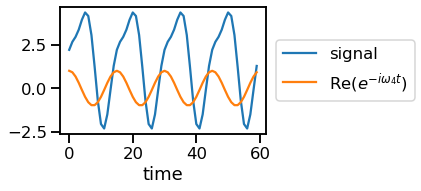

In [11]:
plot_ts(4)

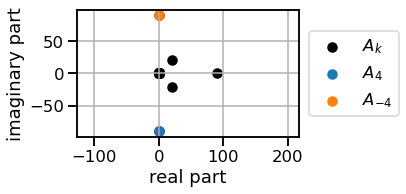

In [12]:
plot_Ak(4)

In [13]:
# panel = pn.Column(
#     freq_slider,
#     plot_ts,
#     plot_Ak,
# )
# panel

In [14]:
# panel.save(
#     "../../lecture/img/8_DDF.html",
#     max_opts=n+1,
#     embed=True,
#     resources=INLINE
# )

To get the amplitude at a particular frequency, we will look at the absolute value of the complex coefficient $A_k$.

To get the correct amplitudes, we need to scale the absolute value by $n$!
Note that the absolute value of a complex number is given $|z| = \sqrt{zz^*}$, so that we may write the amplitude as $\frac{\sqrt{A_kA_k^*}}{n}$

The phase is defined as the angle of the Fourier coefficient with the real axis

$$\theta = \arctan(Im(A_k) / Re(A_k))$$

In [15]:
Ak = np.fft.fftshift(np.fft.fft(signal))
amp = np.abs(Ak)
k = np.arange(-n/2, n/2)

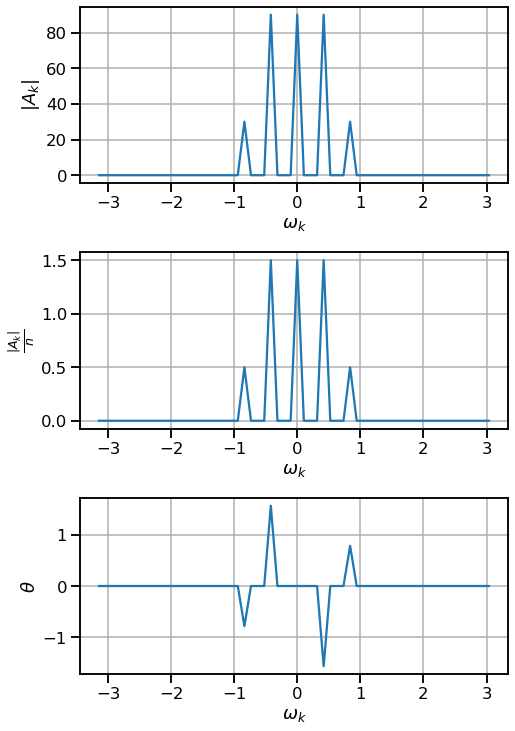

In [16]:
plt.figure(figsize=(7.5, 10.5))

plt.subplot(3, 1, 1)
plt.plot(omega, amp)
plt.ylabel('$|A_k|$')
plt.xlabel('$\omega_k$');
plt.grid();

plt.subplot(3, 1, 2)
plt.plot(omega, amp / n)
plt.ylabel(r'$\frac{|A_k|}{n}$')
plt.xlabel('$\omega_k$');
plt.grid();

plt.subplot(3, 1, 3)
theta = np.angle(Ak)
theta = np.where(np.abs(Ak) >= .1, theta, np.ma.masked)
plt.plot(omega, theta)
plt.ylabel(r'$\theta$')
plt.xlabel('$\omega_k$');
plt.grid();

plt.tight_layout()

# plt.savefig('../../lecture/img/8_amplitude.svg', bbox_inches='tight', pad_inches=.1);

---
## The Powerspectrum

More interesting than the amplitude of a particular Fourier component is the variance that is explained by the variability at a particular frequency. The variance of a single Fourier component is given by

$$ \int_{-\pi}^\pi a^2\sin^2(t)dt = \frac{a^2}{2}$$

Hence, applying the required normalizations (which depend on the numerical implementation of the), we may write the variance explained by oscillations at a particular frequency $\omega_k$ as

$$ \Phi(\omega_k) = \frac{|A_k|^2}{n^2} = \frac{A_k A_k^*}{n^2}$$

$\Phi$ is called the *Powerspectrum*. Since all basis functions of the Fourier decomposition are orthogonal, their covariances are zero. Hence, the variances of all components sum up to the total variance of the signal.

$$Var(f(t)) = \sum_{k=-n/2}^{n/2} \Phi(\omega_k)$$

A more commonly used quantity is *Powerspectral density*, which is defined as

$$ PSD(\omega_k) = \frac{\Phi(\omega_k)}{\Delta f}$$

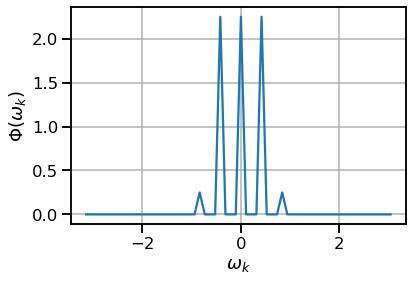

In [17]:
phi = (Ak * Ak.conjugate() / n**2).real

plt.plot(omega, phi)
plt.ylabel(r'$\Phi(\omega_k)$'); plt.xlabel('$\omega_k$');
plt.grid();
# plt.savefig('../../lecture/img/8_powerspectrum.svg', bbox_inches='tight', pad_inches=.1);

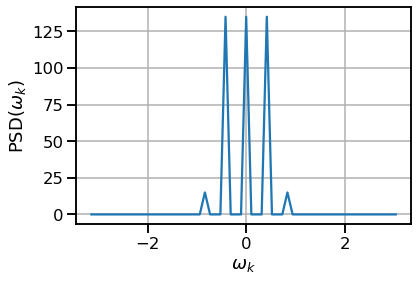

In [18]:
df = 1 / n
plt.plot(omega, phi / df)
plt.ylabel(r'$\operatorname{PSD}(\omega_k)$'); plt.xlabel('$\omega_k$');
plt.grid();
# plt.savefig('../../lecture/img/8_PSD.svg', bbox_inches='tight', pad_inches=.1);

---
## Spectra of real valued data

The spectrum of real valued data is by definition hermitian, that is $A_k = A^*_{-k}$ where the astrisk denotes the complex conjugate. This implies that it is enough to look at the positive side of the spectrum. We can make use of the functions [np.fft.rfft](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.fft.rfft.html) and [np.fft.rfftfreq](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.fft.rfftfreq.html), which return only the positive side lobe of the spectrum. **Note:** By doing that, whenever you sum over the spectrum to obtain the power within a frequency band, you have to multiply the result by two, **except for the zero frequency**! 

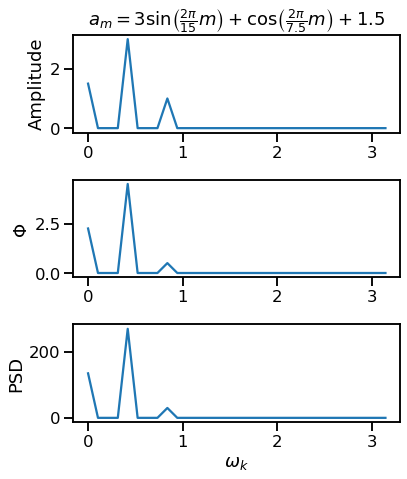

In [38]:
plt.figure(figsize=(6, 7))

plt.subplot(3, 1, 1)
Ak_r = np.fft.rfft(signal)
amp = np.abs(Ak_r) / n
amp[1:] *= 2.
omega_r = 2 * np.pi * np.fft.rfftfreq(n)
plt.plot(omega_r, amp)
plt.title(r'$a_m = 3\sin\left(\frac{2\pi}{15}m\right) + \cos\left(\frac{2\pi}{7.5}m\right) + 1.5$')
# plt.xlabel(r"$\omega_k$");
plt.ylabel(r"Amplitude");

plt.subplot(3, 1, 2)
Phi = (np.abs(Ak_r) / n)**2
Phi[1:] *= 2.
plt.plot(omega_r, Phi)
plt.ylabel("Φ")
# plt.xlabel("$\omega_k$")

plt.subplot(3, 1, 3)
df = 1 / n
PSD = Phi / df
plt.plot(omega_r, PSD)
plt.ylabel("PSD")
plt.xlabel("$\omega_k$")

plt.tight_layout()

# plt.savefig('../../lecture/img/8_one_sided_spectrum.svg', bbox_inches='tight', pad_inches=.1);

---
## Getting dimensions right

Consider a **monthly** time series **covering 24 month**. We want to create a signal that corresponds to the **annual harmonic**. Try to figure out the relevant quantities for that time series, that is the length of sample, sampling frequency, length of the time series in time units, frequency of the signal and the length of the sample meassured in cycles of the signal. What choice do you have to make?

In [36]:
# length of sample
N = 24

# time step [in time units] Time unit is months
dt = 1

# sampling frequency [samples per time unit]
fs = 1 / dt

# frequency of the signal [cycle-per-time-unit]
f_0 = 1 / 12

# length of time series [in time units]
t1 = N * dt

# length of sample in cycles
n_cycle = t1 * f_0

print(N, fs, f_0, t1, n_cycle)

24 1.0 0.08333333333333333 24 2.0


## Example: a pure annual harmonic

We now create the signal that we want to analyse. The signal is a sine function of amplitude 3 and frequency of 1/12 cycle-per-month. Note that the average power of such a signal is given by:

$$\frac{1}{T}\int_0^T a^2\sin^2(2\pi t/T)dt = \frac{a^2}{2} = 4.5$$

Power: 4.3125


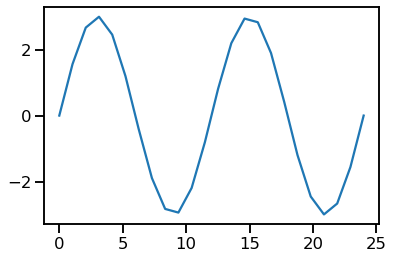

In [37]:
t = np.linspace(0., t1, N)

x = 3. * np.sin(2. * np.pi * f_0 * t)

plt.plot(t, x);
print("Power: {}".format((x**2).mean()))

Now we will first use the plain numpy implementation of the Fourier transform to obtain a spectral estimate of the signal. Therefore, we will make use of the functions [np.fft.fft](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.fft.fft.html) to compute the spectral estimate and [np.fft.fftfreq](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.fft.fftfreq.html) to obtain the corresponding frequency vector. Take a look at their documentation and also at the documentation of the [DFFT implementation in numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/routines.fft.html#implementation-details) to find about the normalization of the Fourier transform.

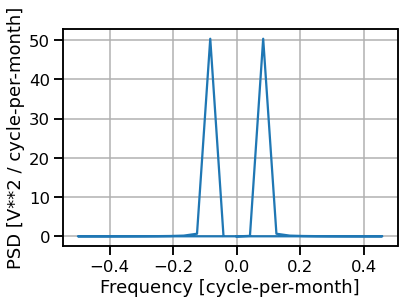

In [38]:
# get the fourier transform of x
f_transform = np.fft.fft(x)

# get the corresponding frequency vector
freq = np.fft.fftfreq(N, 1 / fs)

# compute the periodogram (Powerspectrum)
f_spectrum = np.abs(f_transform)**2 / N**2

# # compute the power spectral density
df = 1 / N / dt
psd = f_spectrum / df

plt.plot(freq, psd);
plt.xlabel("Frequency [cycle-per-month]");
plt.ylabel("PSD [V**2 / cycle-per-month]")
plt.grid();

We can now check if the variance of the spectrum is conserved, that is if the integrated power spectral density is the same as the power of the original time series.
To obtain the power, we have to caclulate

$$P = \sum_i PSD(\omega_i) \Delta f$$

where $PSD(\omega_i)$ is the power spectral density at the frequency bin centred about $\omega_i$.

In [39]:
print("Power: {}".format(
      psd.sum() * df))

Power: 4.312499999999998


---
## Spectra of real valued data

The spectrum of real valued data is by definition hermitian, that is $A_k = A^*_{-k}$ where the astrisk denotes the complex conjugate. This implies that it is enough to look at the positive side of the spectrum. We can make use of the functions [np.fft.rfft](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.fft.rfft.html) and [np.fft.rfftfreq](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.fft.rfftfreq.html), which return only the positive side lobe of the spectrum. **Note:** By doing that, whenever you sum over the spectrum to obtain the power within a frequency band, you have to multiply the result by two, **except for the zero frequency**! 

Power: 4.3137266355703465


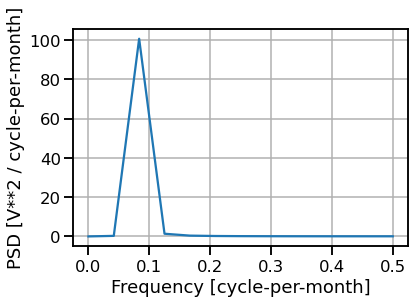

In [41]:
f_transform = np.fft.rfft(x)
freq = np.fft.rfftfreq(N, dt)

f_spectrum = np.abs(f_transform)**2 / N ** 2

df = fs / N / dt
psd = f_spectrum / df

psd[1:] *= 2.

plt.plot(freq, psd); plt.xlabel("Frequency [cycle-per-month]");
plt.ylabel("PSD [V**2 / cycle-per-month]")
plt.grid();

print("Power: {}".format(psd.sum() * df))

We can also use the function [scipy.signal.periodogram](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.periodogram.html) to obtain a periodogram. Note that if the input is real valued, the resulting periodogram will be one-sided. Compare the results of both functions and explain the difference.

Power: 4.312499999999999


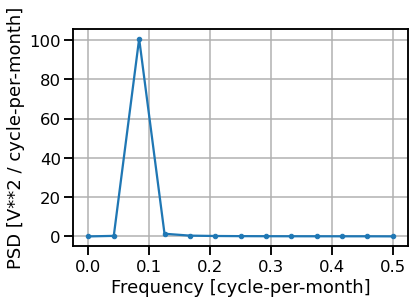

In [42]:
f, psd = sig.periodogram(x, fs)

plt.plot(f, psd, '.-'); plt.xlabel("Frequency [cycle-per-month]");
plt.ylabel("PSD [V**2 / cycle-per-month]")
plt.grid();

print("Power: {}".format(psd.sum() * df))

---
## Bonus: PSD of the seasonal cycle

Construct a seasonal cycle with a 5-daily resolution by using `np.random.rand`. Repeat that time series 1000 times to construct a 1000 year time series of identical years.
- How does the PSD look like?
- At which frequencies is power?

---
## Spectral leakage

Now we increase the length of the time series such that the length of the time series is not an integer multiple of the signals period anymore. 

30 1.0 0.08333333333333333 30.0 2.5
Power: 4.34818716517968


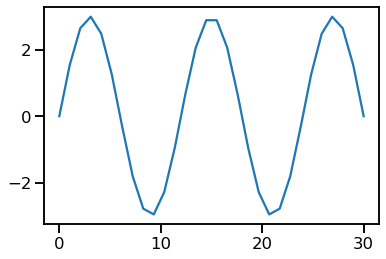

In [51]:
# length of sample
N = 30

# sampling frequency [samples per time unit]
fs = 1.

# bandwidth
df = fs / N

# frequency of the signal [cycle-per-time-unit]
f_0 = 1. / 12.

# length of time series
t1 = N / fs

# length of sample in cycles
n_cycle = N / fs * f_0

print(N, fs, f_0, t1, n_cycle)

t = np.linspace(0., t1, N)

x = 3. * np.sin(2. * np.pi * f_0 * t)
print("Power: {}".format((x[:24]**2).mean()))

plt.plot(t, x)

Now plot the power spectral density of that time series and compare it with the previous one. What is different?

Power: 4.220279408603704


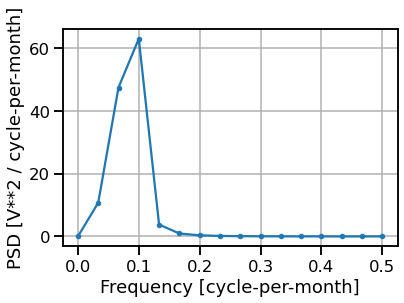

In [52]:
freq, psd = sig.periodogram(x, fs, window=None)

plt.plot(freq, psd, '.-'); plt.xlabel("Frequency [cycle-per-month]");
plt.ylabel("PSD [V**2 / cycle-per-month]")
plt.grid();

print("Power: {}".format((psd * df).sum()))

The reason for the broad peak is the fact that the time series we are analyzing is **finite**. We may extend our time series to infinity and multiply it by a boxcar window function $b(t)$ which is 1 where we have data and zero everywhere else. Then is the Fourier tranform given by

$$ F(\omega) = \int_{-\infty}^\infty b(t)f(t) e^{-i \omega t} dt$$

One can show that for the product of two time series, the Fourier transform is given by the convolution theorem

$$ \int_{-\infty}^\infty f_1(t)f_2(t) e^{-i \omega t} dt = \frac{1}{2\pi}\int_{-\infty}^{\infty}F_1(\omega')F_2(\omega-\omega')d\omega'$$

Hence, the spectrum of a finite time series is the convolution of the true infinite spectrum with the spectrum of a boxcar window function. The spectrum of the window is called *response function*.

Below are response functions of boxcar windows of different length shown.

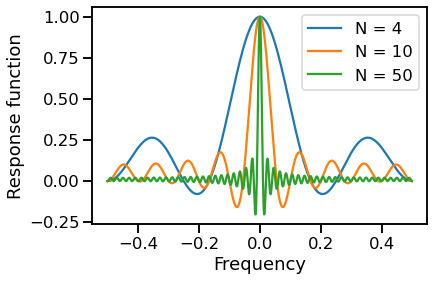

In [46]:
L = 4, 10, 50
N_fill = 1000
for l in L:
    response = np.fft.fftshift(np.fft.fft(np.ones(l), N_fill))
    freq = np.fft.fftshift(np.fft.fftfreq(N_fill))
    plt.plot(freq, response.real / l, label="N = {}".format(l))
plt.ylabel("Response function")
plt.xlabel("Frequency")
plt.legend();

To mitigate the spectral leakage, we will apply **tapering**. Therefore, we multiply the time series by a window function. There exists quite a number of window functions and the choice depends on the use case. For tapering, one may typically use a hanning window. The ideal response function would have a narrow central peak and insignificant side lobes.

In [47]:
win = np.hanning(N)

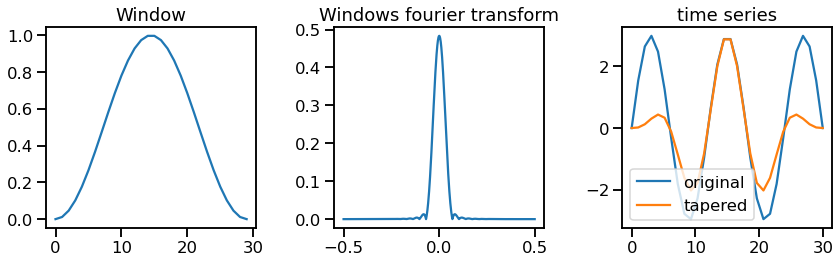

In [48]:
def plot_window(window, x):
    plt.subplot(131)
    plt.plot(window); plt.title("Window");

    plt.subplot(132)
    plt.plot(
        np.fft.fftshift(np.fft.fftfreq(N_fill, d=1/fs)),
        np.abs(np.fft.fftshift(np.fft.fft(window, n=N_fill))) / N)
    plt.title("Windows fourier transform")

    plt.subplot(133)
    plt.plot(t, x, label="original")
    plt.plot(t, x*window, label="tapered")
    plt.title("time series"); plt.legend()

    plt.gcf().set_size_inches(12., 4.)
    plt.tight_layout()

plot_window(win, x)

In [61]:
(win ** 2).mean()

0.36249999999999993

Now try to estimate the psd of the tapered signal using `numpy.fft.rfft` and `scipy.signal.periodogram` with the `window=hann` argument. Why are they different?

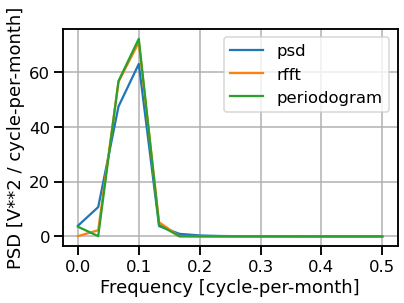

In [63]:
f_transform = np.fft.rfft(x)
f_spectrum = np.abs(f_transform)**2 / N ** 2
psd = f_spectrum / df
psd[1:] *= 2.


f_transform = np.fft.rfft(win * x)
f_spectrum = np.abs(f_transform)**2 / N ** 2
psd_rfft = f_spectrum / df / (win ** 2).mean()
psd_rfft[1:] *= 2.

freq, psd_periodogram = sig.periodogram(x, fs, window="hann")

plt.plot(freq, psd, label="psd")
plt.plot(freq, psd_rfft, label="rfft");
plt.plot(freq, psd_periodogram, label="periodogram");
plt.xlabel("Frequency [cycle-per-month]");
plt.ylabel("PSD [V**2 / cycle-per-month]")
plt.legend()
plt.grid();

---
## Aliasing

Aliasing is the effect of non-resolved variability on the spectrum. Think about sampling a sine wave. If the sampling frequency is of the same order than the wave's frequency then is its power aliased to lower frequencies. 

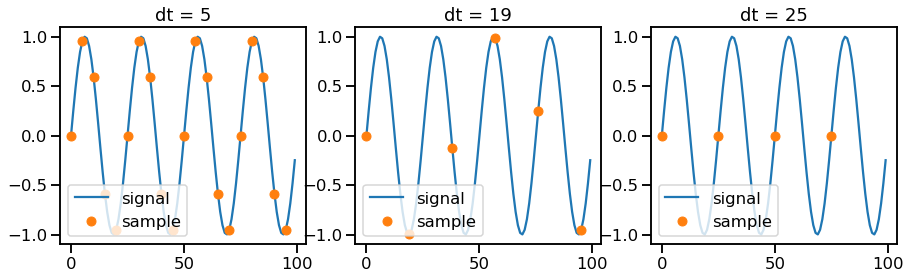

In [64]:
t = np.arange(100)
signal = np.sin(2 * np.pi * t / 25)

def aliasing(dt=5):
    plt.plot(t, signal, label="signal")
    plt.plot(t[::dt], signal[::dt], 'o', label="sample")
    plt.legend(loc=3)
    
#     fig = plt.gcf()
#     plt.close()
#     return fig

# pn.interact(aliasing, dt=(1, 100))
plt.figure(figsize=(15, 4))
for i, dt in enumerate((5, 19, 25)):
    plt.subplot(1, 3, i + 1)
    aliasing(dt)
    plt.title("dt = {}".format(dt))

Unresolved variability is aliased to the resolved part of the spectrum. The spectrum of the aliased variability is the mirror image of the unresolved variability at the Nyquist frequency.

<img src='http://www.lifelong-learners.com/pde/com/SYL/s4img36.gif' />

The only option to escape the aliasing problem is to measure at high frequencies and then bin-average the data to lower sampling rates. This removes all high-frequency noise from the observations.

---
## Consistency of spectral estimator

Consider a white noise signal. It's theoretical spectrum is a flat line. Let's see how the spectral estimate looks like depending on the length of the time series.

Column
    [0] Column
        [0] IntSlider(end=1000, name='N', start=100, step=10, value=550)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00016')
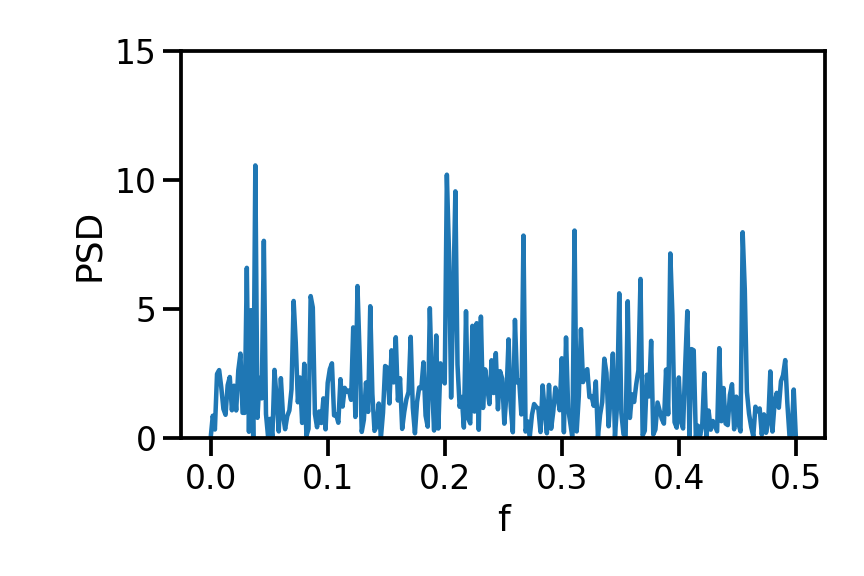

In [4]:
noise = np.random.randn(1000)

def spectrum_whitenoise(N):
    freq, fft = sig.periodogram(noise[:N], fs=1.)
    plt.plot(freq, fft)
    plt.xlabel('f')
    plt.ylabel('PSD')
    plt.ylim(0., 15.)
    fig = plt.gcf()
    plt.tight_layout()
    plt.close()
    return fig

# plt.figure(figsize=(15, 4))
# for i, N in enumerate((100, 500, 1000)):
#     plt.subplot(1, 3, i + 1)
#     spectrum_whitenoise(N)
#     plt.title("N = {}".format(N))
pn.interact(spectrum_whitenoise, N=(100, 1000, 10))

We can see that with increasing length of the time series we get more spectral estimates. However, the variance of the spectral estimates is the same. The reason is, because we get more estimates, the degrees of freedom of a single estimate stays constant. That makes the Fourier transformation an **inconsistent estimator**.

The spectral estimates for each frequency bin is $\chi^2_2$ distributed. The variance of a $\chi^2_2$ distribution equals the mean of the distribution. Hence, the more power there is in a frequency bin, the larger is the spread of the estimate. 

In what follows we want to improve the spectral estimate in the sense that we want to reduce its spread.

Now we want to look at more realistic examples, that is an interesting signal covered in noise. For that we construct a time series of an annual harmonic over 100 years having 5-daily sampling frequency.
Since we now know how the interpret the output of [scipy.signal.periodogram](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.periodogram.html), we will use that function for simplicity. 

In [5]:
# length of sample
N = 73 * 100

# sampling frequency [samples per time unit]
fs = 73.

# frequency of the signal [cycle-per-time-unit]
f_0 = 1.

# bandwidth
df = fs / N

# length of time series
t1 = N / fs

# length of sample in cycles
n_cycle = N / fs * f_0

Now we define a function that will produce a white noise. This type of noise has the same spectral power at all frequencies. It is obtained by simply drawing from a normal distribution.

In [6]:
def white_noise(t, amp):
    return amp * np.random.randn(len(t))

Variance of noise: 15.583615714328786


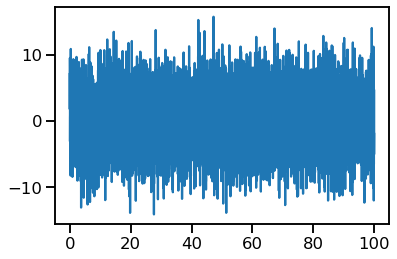

In [9]:
np.random.seed(0)

t = np.linspace(0., t1, N)

# Variance of the noise: 4**2 = 16
noise = white_noise(t, 4.)

# amplitude of the annual harmonic: 2.
x = 2. * np.sin(2. * np.pi * f_0 * t) + noise

plt.plot(t, x);
print("Variance of noise: {}".format(noise.var()))

Now we compute and plot the periodogram without any tapering applied. Try to recover the amplitude of the annual cycle and the variance of the noise. For the noise you can exploit that the annual cycle is not correlated with the noise and hence their variances add up to the total variance.

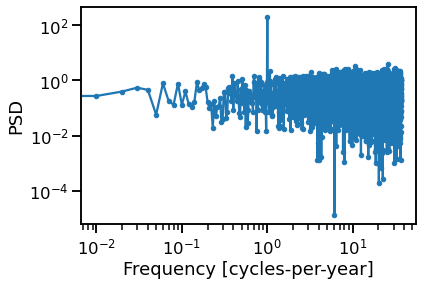

In [13]:
f, psd = sig.periodogram(x, fs, window=None, scaling="density", detrend=False)

plt.loglog(f, psd, '.-');
plt.ylabel("PSD")
plt.xlabel("Frequency [cycles-per-year]");

In [17]:
# amplitude of the annual cycle signal
p_ann = np.sqrt(2 * psd[np.argmin(np.abs(f - 1.))] * df)

print("Amplitude of annual cycle: {}".format(p_ann))

# variance of the noise
p_noise = (psd * df).sum() - p_ann**2 / 2
print("Variance of noise: {}".format(p_noise))

Amplitude of annual cycle: 2.0072719382365585
Variance of noise: 15.586913712310155


Now lets try to use tapering to improve the noisy power density spectrum. Use a hann window with the periodogram function.
- Which parts of the spectrum do visually improve?
- What happens to the amplitude of the annual cycle and why?
- What do we have to do to get back the original power?
- Why is the variance of the noise not affected by tapering?

3651


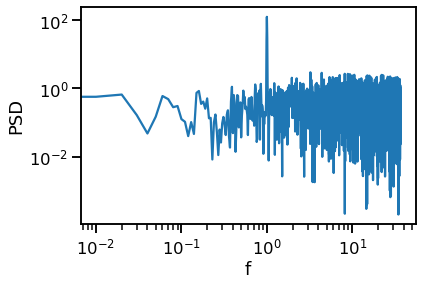

In [27]:
f, psd = sig.periodogram(x, fs, window="hann", scaling="density", detrend=False)

plt.loglog(f, psd);
plt.ylabel('PSD'); plt.xlabel('f');
print(len(psd))

In [22]:
# amplitude of the annual cycle signal
i_ann = np.argmin(np.abs(f - 1.))
p_ann = np.sqrt(2 * psd[i_ann-2:i_ann+3].sum() * df)

print("Amplitude of annual cycle: {}".format(p_ann))

# variance of the noise
p_noise = (psd * df).sum() - p_ann**2 / 2
print("Variance of noise: {}".format(p_noise))

Amplitude of annual cycle: 1.9170391005125973
Variance of noise: 15.744108393392592


## Windowing: Welchs method

Since tapering did not helped a lot, there is yet another method that may be used to reduce the noise, i.e. the variance in the spectral estimate. In Welchs method consists of the following steps:

1. Split the time series in segments
2. Taper each segment using a window function
3. Estimate the spectrum for each segment
4. Average over all spectral estimates

Typically, the segments overlap each other, because the tapering would else lead to a downweighting of certain parts of the time series. Note that, if the segments overlap, the spectral estimates are not independent of each other and that you have to take this into account when assesing the statistical significance of the estimate.

In Python you may want to use [scipy.signal.welch](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.periodogram.html) for performing Welchs method. Take a look at the documentation!

Apply Welchs method to estimate the spectrum of the time series. Choose segments of 10 year length and use a hann window for tapering.

- How does the frequency resolution differ from the previous result?
- At which end of the spectrum do you loose information?
- Why is the peak of the annual cycle smeared out?
- How does the noise part of the spectrum looks like? Why is the variance of the estimates reduced and how is the reduction related to the number of segments?
- Can you still recover the amplitude of the annual cycle and the variance of the noise?

In [24]:
len(x)

7300

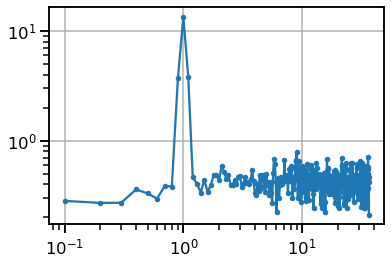

In [36]:
f, psd = sig.welch(x, fs, nperseg=730)

plt.loglog(f[1:], psd[1:], '.-')
plt.grid();